In [26]:

from tqdm import tqdm
import pickle
import pandas as pd
from pathlib import Path
import numpy as np
import copy
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

sys.path.append('/mnt/c/Users/lslat/Code/')
sys.path.append('/mnt/c/Users/lslat/QiskitProjects/VariationalWavefunction/')

from quantum_kernel.code.utils import get_dataset
from quantum_kernel.code.visualization_utils import aggregate_folder
from quantum_kernel.code.kernel_measures import kernel_geometry
from quantum_kernel.code.utils import compute_additional_fields

font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 20}

rc('font', **font)

tqdm.pandas()

In [27]:
# Get kernel results for the different ml models and dataset.d
dfs = {}
dataset_name='kmnist'
folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQPm/"+dataset_name,'Sparse_IQPm'),
    ("/mnt/c/Users/lslat/Data/QK_project/results/rbf/"+dataset_name, "rbf"),
    ("/mnt/c/Users/lslat/Data/QK_project/results/laplacian/"+dataset_name, 'laplacian'),
]

for folder, kernel_name in folders:
    if dataset_name in dfs:
        temp = aggregate_folder(folder, dataset_name, kernel_name=kernel_name)[
            dataset_name]
        dfs[dataset_name] = pd.concat([dfs[dataset_name], temp])
    else:
        dfs[dataset_name] = aggregate_folder(
            folder, dataset_name, kernel_name=kernel_name)[dataset_name]

save_folder='/mnt/c/Users/lslat/Data/QK_project/figs/'


For /mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQPm/kmnist, using aggregated pickle from /mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQPm/kmnist/aggregated.p
For /mnt/c/Users/lslat/Data/QK_project/results/rbf/kmnist, using aggregated pickle from /mnt/c/Users/lslat/Data/QK_project/results/rbf/kmnist/aggregated.p
For /mnt/c/Users/lslat/Data/QK_project/results/laplacian/kmnist, using aggregated pickle from /mnt/c/Users/lslat/Data/QK_project/results/laplacian/kmnist/aggregated.p


In [20]:
df = dfs[dataset_name]
rbf_df = df[(df['kernel_name'] == 'rbf') & (df['dataset_dim'] == 18)]
laplacian_df = df[(df['kernel_name'] == 'laplacian') & (df['dataset_dim'] == 18)]
sparse_iqpm_df = df[(df['kernel_name'] == 'Sparse_IQPm') & (df['dataset_dim'] == 18)]
iqp_df=sparse_iqpm_df[(sparse_iqpm_df['log_int_scaling_factor']==0.0)]

In [21]:
# find the best performing model idx.
best_rbf_idx = np.argmax(rbf_df['test_score'])
best_laplacian_idx=np.argmax(laplacian_df['test_score'])
best_iqp_idx = np.argmax(iqp_df['test_score'])
# careful here. can't do the naive rbf_df['test_score'][idx] as its not a list.
print('Best rbf test score: ', rbf_df.iloc[best_rbf_idx]['test_score'])
print('Best laplacian test score: ', laplacian_df.iloc[best_laplacian_idx]['test_score'])
print('Best iqp test score: ', iqp_df.iloc[best_iqp_idx]['test_score'])
#

Best rbf test score:  0.9356742697078831
Best laplacian test score:  0.9150660264105642
Best iqp test score:  0.8846538615446178


0.0
0.0
0.0


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/lslat/Data/QK_project/figs/kmnist_kernel_eigenvalue_distributions.pdf'

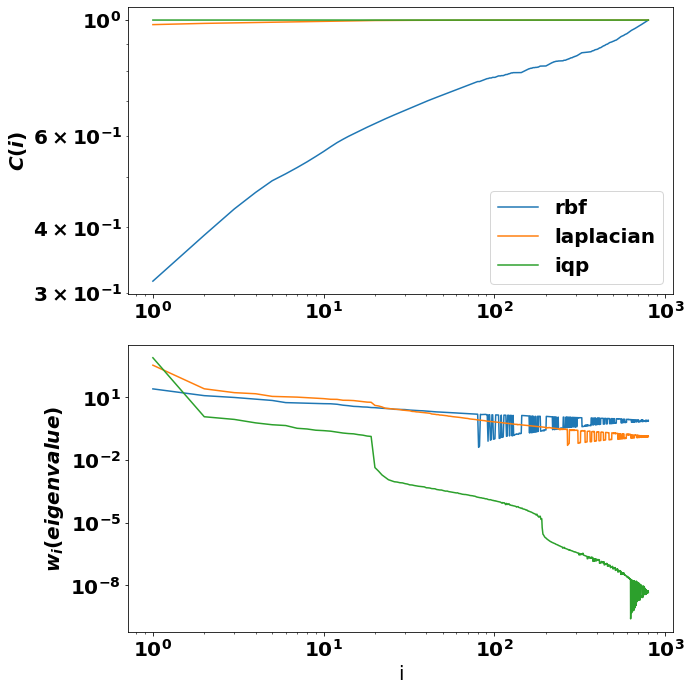

In [30]:
fig,axs=plt.subplots(2,figsize=(10,10))
for i,(kernel_name,df) in enumerate([('rbf',rbf_df),('laplacian',laplacian_df),('iqp',iqp_df)]):
    best_idx = np.argmax(df['test_score'])
    K=df.iloc[best_idx]['qkern_matrix_train']
    K=(K+K.T)/2
    w,_=np.linalg.eig(K)
    c=kernel_geometry.compute_cumulative_power_distribution(K)
    axs[0].plot(np.linspace(1,len(c),len(c)),c,label=kernel_name)
    axs[1].plot(np.linspace(1,len(c),len(c)),w)
axs[0].set_ylabel('$C(i)$')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()

axs[1].set_xlabel('i')
axs[1].set_ylabel('$w_i (eigenvalue)$')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
fig.tight_layout()
#fig.savefig(f'{save_folder}{dataset_name}_kernel_eigenvalue_distributions.pdf')